In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Change to use continuous adjoint method
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import application_examples.helpers.plotting as plt

# Learning a linear system

## Model 1: Can we approximate the vector field with a simple neural network?

### Hyperparameters

In [2]:
method  = 'dopri5'
data_size = 1000
batch_time = 10
batch_size = 20
niters = 4000
test_freq = 20
terminal_time = 25.
learning_rate = 1e-3
# Stopping variables
eps = 1e-2
tol = 1

### The data

In order to train the model, let's create a "real" system to use as training data. 

In [3]:
t = torch.linspace(0., terminal_time, data_size)


#### Define the real system
First define the real system, which is a linear system of ODEs with a known solution. Then calculate the solution of the system using the `odeint` function from `torchdiffeq` and plot the solution.

In [4]:
true_y0 = torch.tensor([[2., 0.]])
true_A = torch.tensor([[-0.1, 3.0], [-3.0, -0.1]])

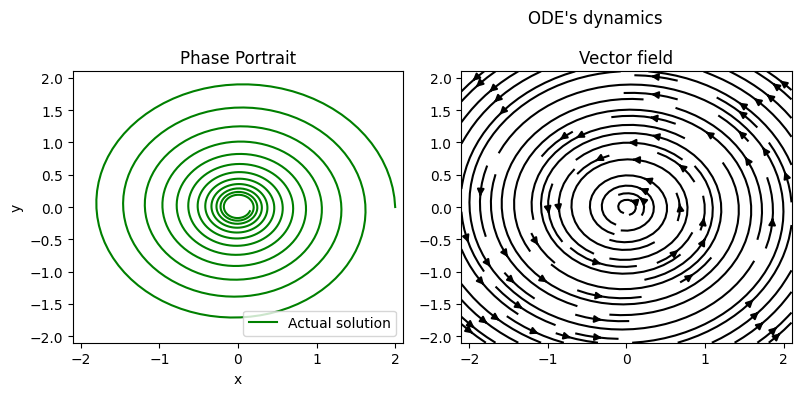

In [5]:
true_vector_field = lambda t, y: torch.mm(y, true_A)
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')
plt.plot_ode(true_y, true_vector_field)

### The model

In [6]:
# Define a Neural Network to learn the vector field
class ODEnn(nn.Module):

    def __init__(self):
        super(ODEnn, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODEnn()

#### Train the neural network

In [7]:
def get_batch(true_y, t): # TODO put this in helpers
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [8]:
# TODO add training function in helpers
optimizer = optim.RMSprop(func.parameters(), lr=learning_rate)

losses = [] # List that will store the loss at each iteration

for i in range(niters):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(true_y, t)
    pred_y = odeint(func, batch_y0, batch_t, method=method)
    loss = torch.norm(pred_y - batch_y)
    loss.backward()
    optimizer.step()

    # Visualise training process
    if i % test_freq == 0:
        with torch.no_grad():
            # Compute loss using all data
            pred_y = odeint(func, true_y0, t, method=method)
            loss = torch.norm(pred_y - true_y)
            losses.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            
# Compute loss using all data
pred_y = odeint(func, true_y0, t, method=method)
loss = torch.norm(pred_y - true_y)
losses.append(loss.item())
print('Iter {:04d} | Total Final Loss {:.6f}'.format(niters, loss.item()))
    

Iter 0000 | Total Loss 58.863605
Iter 0020 | Total Loss 36.631451
Iter 0040 | Total Loss 33.819481
Iter 0060 | Total Loss 33.195953
Iter 0080 | Total Loss 32.534847
Iter 0100 | Total Loss 10.084336
Iter 0120 | Total Loss 11.064834
Iter 0140 | Total Loss 11.933002
Iter 0160 | Total Loss 10.346097
Iter 0180 | Total Loss 9.998639
Iter 0200 | Total Loss 9.743698
Iter 0220 | Total Loss 10.879827
Iter 0240 | Total Loss 9.769752
Iter 0260 | Total Loss 9.812540
Iter 0280 | Total Loss 9.489003
Iter 0300 | Total Loss 9.088651
Iter 0320 | Total Loss 9.948332
Iter 0340 | Total Loss 9.728212
Iter 0360 | Total Loss 9.821699
Iter 0380 | Total Loss 8.860367
Iter 0400 | Total Loss 8.680382
Iter 0420 | Total Loss 9.677000
Iter 0440 | Total Loss 8.710167
Iter 0460 | Total Loss 9.294116
Iter 0480 | Total Loss 9.119390
Iter 0500 | Total Loss 8.826980
Iter 0520 | Total Loss 9.957191
Iter 0540 | Total Loss 9.046481
Iter 0560 | Total Loss 8.656669
Iter 0580 | Total Loss 9.502340
Iter 0600 | Total Loss 8.02518

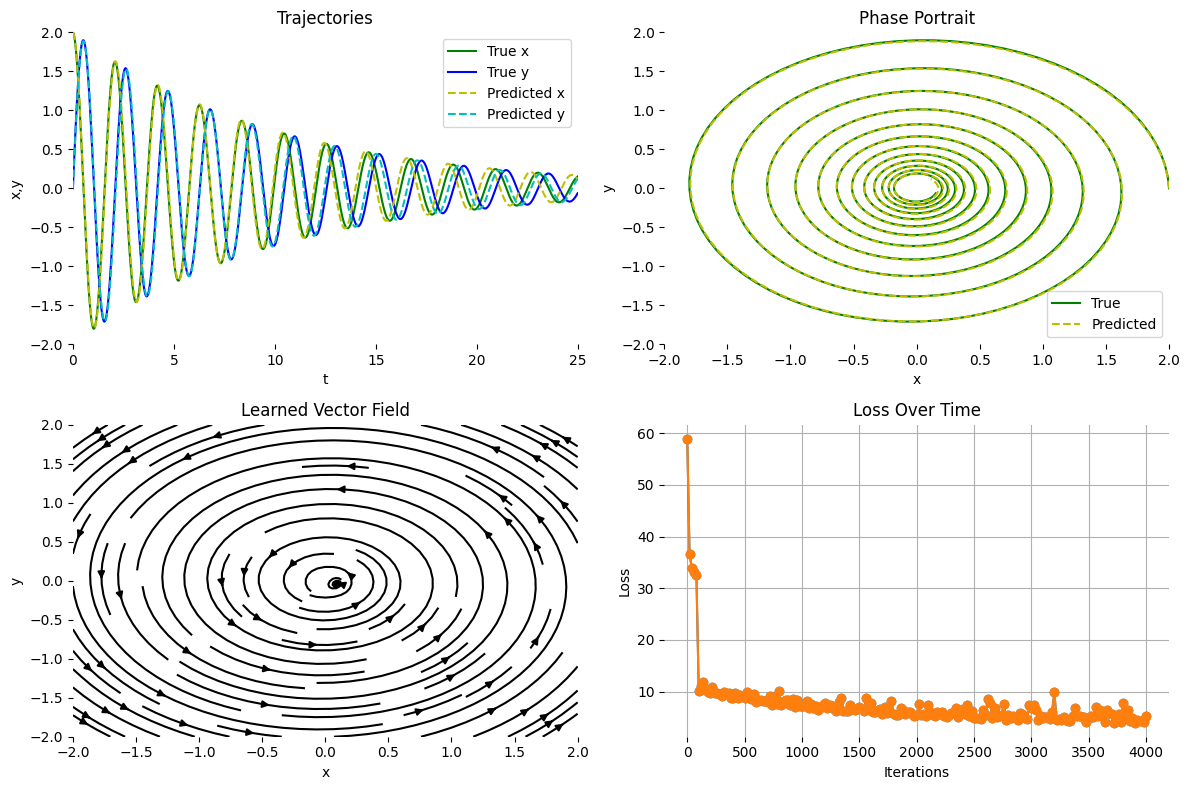

In [9]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=method), t, func, losses, test_freq)

### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [10]:
# Double time and data points
test_t = torch.linspace(0., 2 * terminal_time, 2 * data_size)

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method='dopri5')

Total Test Loss 3.303132


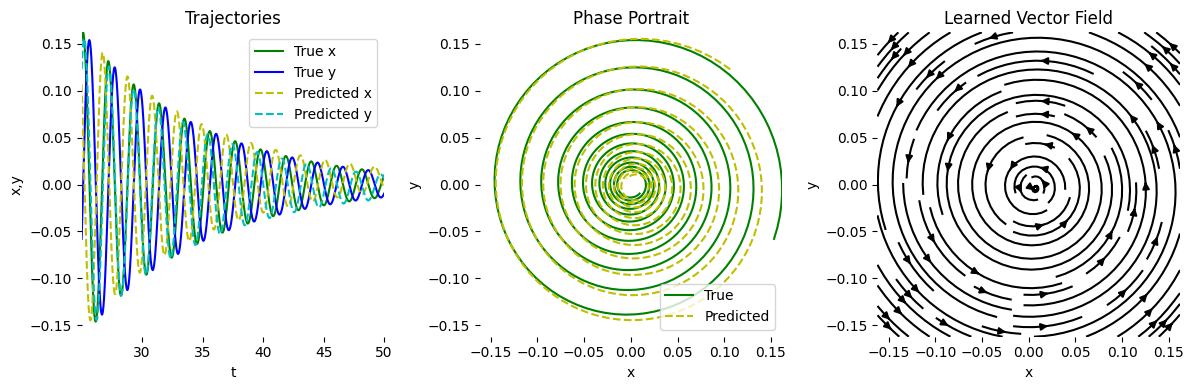

In [11]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=method) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-data_size:] - test_true_y[-data_size:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-data_size:], odeint(func, true_y0, test_t, method=method)[-data_size:], test_t[-data_size:], func)

It is expected that the loss will be smaller because the points are much closer together. However, when looking at the graph one can appreciate the solution goes faster than the actual system.

Actually, it seems the model is not able to learn the vector trajectory of the solution with much precision after some time. 

### Can the model train with a different initial condition?

In this section we define a different $y_0$ and train the model again.

In [12]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [13]:
optimizer = optim.RMSprop(func.parameters(), lr=learning_rate)

new_losses = [] # List that will store the loss at each iteration

for i in range(niters):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(new_true_y, t)
    new_pred_y = odeint(func, batch_y0, batch_t, method=method)
    loss = torch.norm(new_pred_y - batch_y)
    loss.backward()
    optimizer.step()

    # Visualise training process
    if i % test_freq == 0:
        with torch.no_grad():
            # Compute loss using all data
            new_pred_y = odeint(func, new_true_y0, t, method=method)
            loss = torch.norm(new_pred_y - new_true_y)
            new_losses.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            
# Compute loss using all data
new_pred_y = odeint(func, new_true_y0, t, method=method)
loss = torch.norm(new_pred_y - new_true_y)
new_losses.append(loss.item())
print('Iter {:04d} | Total Final Loss {:.6f}'.format(niters, loss.item()))

Iter 0000 | Total Loss 175.614014
Iter 0020 | Total Loss 197.045731
Iter 0040 | Total Loss 186.052353
Iter 0060 | Total Loss 206.895203
Iter 0080 | Total Loss 197.884262
Iter 0100 | Total Loss 184.786011
Iter 0120 | Total Loss 181.035751
Iter 0140 | Total Loss 165.601791
Iter 0160 | Total Loss 177.781143
Iter 0180 | Total Loss 171.346283
Iter 0200 | Total Loss 178.425568
Iter 0220 | Total Loss 161.883621
Iter 0240 | Total Loss 156.037460
Iter 0260 | Total Loss 149.613754
Iter 0280 | Total Loss 146.484055
Iter 0300 | Total Loss 142.594147
Iter 0320 | Total Loss 144.706497
Iter 0340 | Total Loss 156.385757
Iter 0360 | Total Loss 167.735229
Iter 0380 | Total Loss 134.556641
Iter 0400 | Total Loss 131.011856
Iter 0420 | Total Loss 131.002533
Iter 0440 | Total Loss 130.394470
Iter 0460 | Total Loss 147.986465
Iter 0480 | Total Loss 128.705872
Iter 0500 | Total Loss 145.484406
Iter 0520 | Total Loss 145.125290
Iter 0540 | Total Loss 128.634445
Iter 0560 | Total Loss 122.390938
Iter 0580 | To

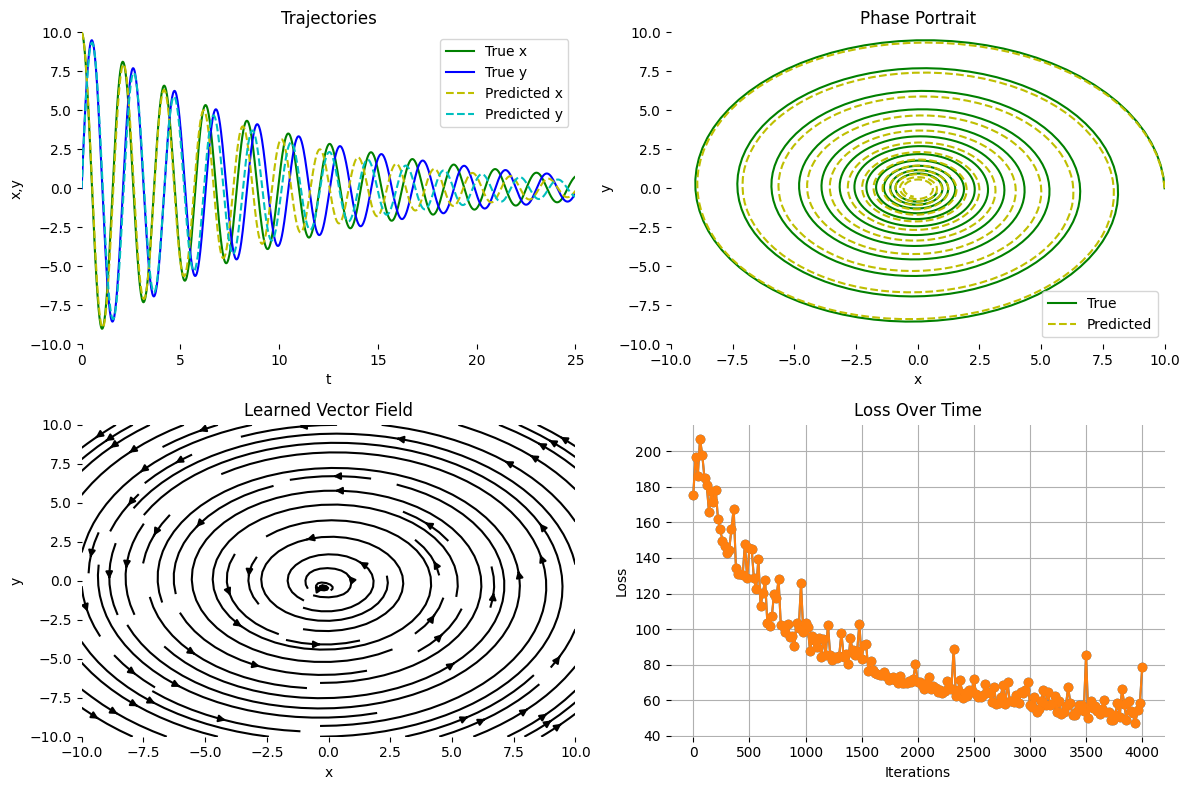

In [14]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=method), t, func, new_losses, test_freq)

Observe that the results are considerably worse. This is because the vector field has much larger values in the vicinity of the new initial condition. Not only does this cause the error, in general, to be much larger, but it also makes the system more sensitive to small discrepancies in the predicted points, which add up to a large error.

## Model 2: Can we improve the results by simplifying the model?
This is a very simple system. In fact it the vector field we are trying to learn is linear. Therefore, the neural network doesn't need to be able to learn a non-linear function. Let's try to simplify the model by removing the hidden layer and the activation function and reducing the number of neurons in the hidden layer.

### New hyperparameters

In [15]:
data_size = 2500
batch_time = 10
batch_size = 40
niters = 20000
test_freq = 50
terminal_time = 25.
learning_rate = 1e-4

### The data

In [16]:
t = torch.linspace(0., terminal_time, data_size)


In [17]:
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')

### The model

In [18]:
# Define a Neural Network to learn the vector field
class ODELin(nn.Module):

    def __init__(self):
        super(ODELin, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 2 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 4),
            nn.Linear(4, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODELin()

#### Train the neural network

In [19]:
optimizer = optim.RMSprop(func.parameters(), lr=learning_rate)

losses = [] # List that will store the loss at each iteration
prev_loss = float('inf')

for i in range(niters):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(true_y, t)
    pred_y = odeint(func, batch_y0, batch_t, method=method)
    loss = torch.norm(pred_y - batch_y)
    loss.backward()
    optimizer.step()

    # Visualise training process
    if i % test_freq == 0:
        with torch.no_grad():
            # Compute loss using all data
            pred_y = odeint(func, true_y0, t, method=method)
            loss = torch.norm(pred_y - true_y)
            losses.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            if (abs(loss.item() - prev_loss) < eps and loss.item() < tol) or (loss.item() < eps):
                break
            prev_loss = loss.item()
            
# Compute loss using all data
pred_y = odeint(func, true_y0, t, method=method)
loss = torch.norm(pred_y - true_y)
losses.append(loss.item())
print('Total Final Loss {:.6f}'.format(loss.item()))
    

Iter 0000 | Total Loss 122.905396
Iter 0050 | Total Loss 116.717125
Iter 0100 | Total Loss 113.350700
Iter 0150 | Total Loss 109.380203
Iter 0200 | Total Loss 105.099861
Iter 0250 | Total Loss 101.640106
Iter 0300 | Total Loss 99.087242
Iter 0350 | Total Loss 95.819229
Iter 0400 | Total Loss 93.738800
Iter 0450 | Total Loss 90.500641
Iter 0500 | Total Loss 87.145500
Iter 0550 | Total Loss 84.894447
Iter 0600 | Total Loss 82.430069
Iter 0650 | Total Loss 80.296227
Iter 0700 | Total Loss 79.203125
Iter 0750 | Total Loss 78.018387
Iter 0800 | Total Loss 77.076103
Iter 0850 | Total Loss 75.609848
Iter 0900 | Total Loss 75.185852
Iter 0950 | Total Loss 74.571487
Iter 1000 | Total Loss 73.960075
Iter 1050 | Total Loss 73.336884
Iter 1100 | Total Loss 73.445984
Iter 1150 | Total Loss 73.578423
Iter 1200 | Total Loss 74.464302
Iter 1250 | Total Loss 75.034714
Iter 1300 | Total Loss 75.289680
Iter 1350 | Total Loss 76.215408
Iter 1400 | Total Loss 76.773087
Iter 1450 | Total Loss 76.279381
Iter

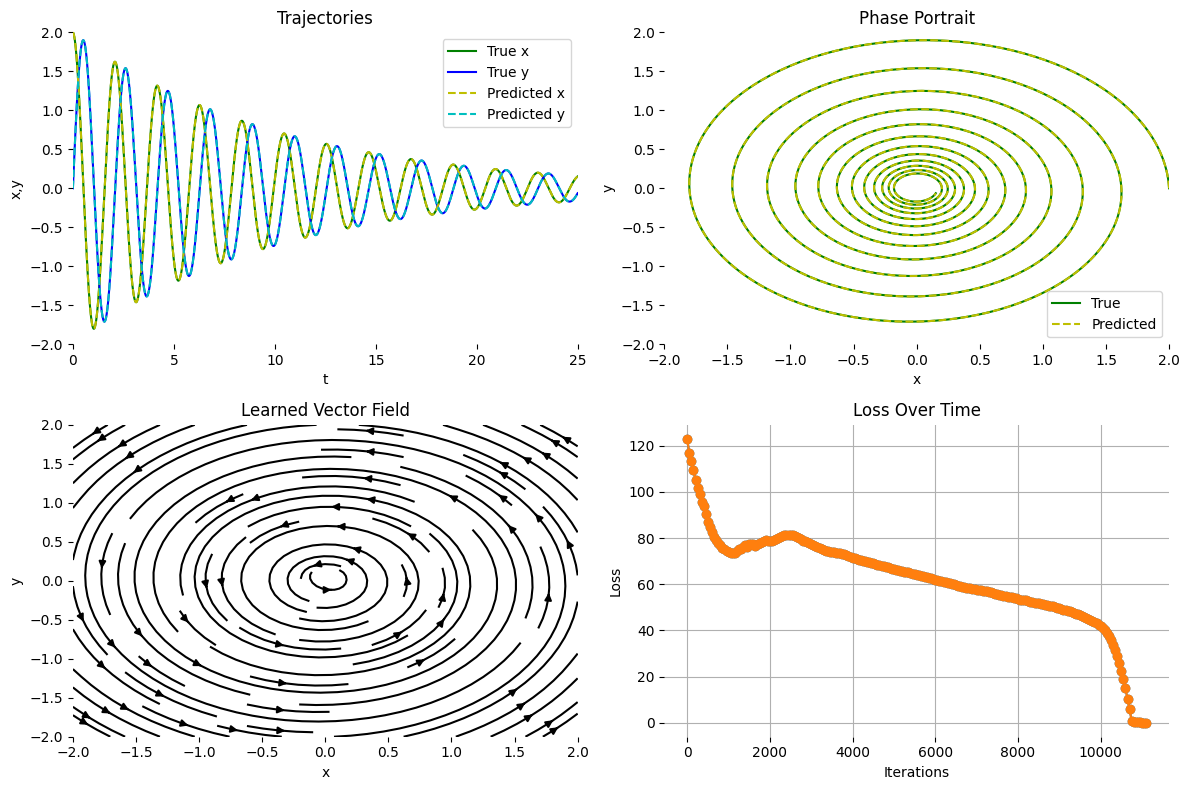

In [20]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=method), t, func, losses, test_freq)

### Try it with a different initial condition

In [21]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [22]:
optimizer = optim.RMSprop(func.parameters(), lr=learning_rate)

new_losses = [] # List that will store the loss at each iteration

for i in range(niters):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(new_true_y, t)
    new_pred_y = odeint(func, batch_y0, batch_t, method=method)
    loss = torch.norm(new_pred_y - batch_y)
    loss.backward()
    optimizer.step()

    # Visualise training process
    if i % test_freq == 0:
        with torch.no_grad():
            # Compute loss using all data
            new_pred_y = odeint(func, new_true_y0, t, method=method)
            loss = torch.norm(new_pred_y - new_true_y)
            new_losses.append(loss.item())
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            
# Compute loss using all data
new_pred_y = odeint(func, new_true_y0, t, method=method)
loss = torch.norm(new_pred_y - new_true_y)
new_losses.append(loss.item())
print('Total Final Loss {:.6f}'.format(loss.item()))

Iter 0000 | Total Loss 6.557541
Iter 0050 | Total Loss 0.395348
Iter 0100 | Total Loss 0.874207
Iter 0150 | Total Loss 0.670357
Iter 0200 | Total Loss 0.734451
Iter 0250 | Total Loss 0.283558
Iter 0300 | Total Loss 0.404591
Iter 0350 | Total Loss 0.163610
Iter 0400 | Total Loss 0.363285
Iter 0450 | Total Loss 0.208076
Iter 0500 | Total Loss 0.124258
Iter 0550 | Total Loss 0.391860
Iter 0600 | Total Loss 0.414932
Iter 0650 | Total Loss 0.116328
Iter 0700 | Total Loss 0.252319
Iter 0750 | Total Loss 0.422236
Iter 0800 | Total Loss 0.415847
Iter 0850 | Total Loss 0.262563
Iter 0900 | Total Loss 0.291718
Iter 0950 | Total Loss 0.526476
Iter 1000 | Total Loss 0.459417
Iter 1050 | Total Loss 0.631387
Iter 1100 | Total Loss 0.421143
Iter 1150 | Total Loss 0.329963
Iter 1200 | Total Loss 0.504969
Iter 1250 | Total Loss 0.314747
Iter 1300 | Total Loss 0.259957
Iter 1350 | Total Loss 0.368497
Iter 1400 | Total Loss 0.312055
Iter 1450 | Total Loss 0.302371
Iter 1500 | Total Loss 0.546378
Iter 155

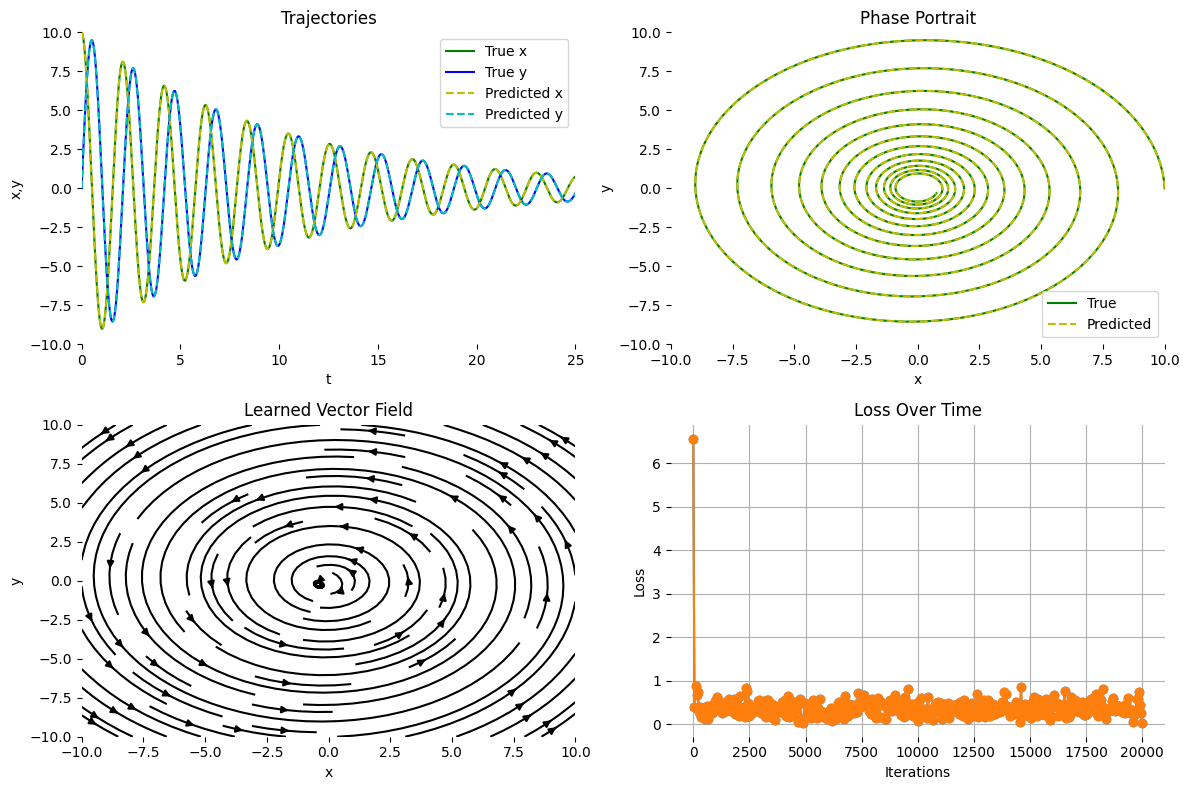

In [23]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=method), t, func, new_losses, test_freq)

## Results
It turns out that the new simplified model works much better in this case. Even when learning with the harder initial condition, the model is able to learn the vector field and predict the solution of the system with precision.